
### Spectroscopic Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2024  

In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\keena\Documents\University\python_scripts")

import Function_files.data_functions as dat
from Function_files.filter_functions import smooth_data
from Function_files.math_functions import bin_data, OD_calc
from Function_files.plotting_class import Plotter
import Spectroscopy.PrYVO.PrYVO_config as config_file

import os
plt = Plotter()

In [2]:
# import config file dictionary
dir = config_file.root + config_file.file
# interogate directory to extract folder and file names
folder_list, file_list = dat.dir_interrogate(path=dir, extensions=config_file.extensions, exceptions=config_file.exceptions)
# create dictionary for indexing folders and files
fol_i = dat.make_index_dict(folder_list)
fil_i = [dat.make_index_dict(file_sub_list) for file_sub_list in file_list]
# assemble reference paths
ref_paths = dat.search_paths(folder_list, file_list, include=config_file.refs)
ref_path_list = [os.path.join(dir, x) for x in ref_paths]
# assemble spectra paths
spectra_paths = dat.search_paths(folder_list, file_list, exclude=config_file.refs)
spectra_paths_list = [os.path.join(dir, x) for spectra_lists in spectra_paths for x in spectra_lists]
# find polarisation numbers from reference file names
polarisations = [dat.find_numbers(os.path.split(path)[1], '\d+')[0] for path in ref_paths]
# extract data from the folders
ref_metadata, ref_data = dat.spectrum_extract(ref_path_list, keys=polarisations)
spectra_metadata, spectra_data = dat.spectrum_extract(spectra_paths_list, keys=polarisations)
spectra_waves, spectra_intensities = dat.separate_lists(spectra_data) 
reference_waves, reference_intensities = dat.separate_lists(ref_data)

In [3]:
# calculate OD and correct for power variance
OD_sets = [[OD_calc(ref_data=ref[0], trans_data=spectra, c_factor=config_file.correction) for spectra in spectra_set] for ref, spectra_set in zip(reference_intensities, spectra_intensities)]
# subtract mean value to compensate for background
zeroed_OD = [[values - bin_data(values, 100) for values in spectra] for spectra in OD_sets]
# create subtracted set (minus lowest temp data)
subtracted_OD = [[values - spectra[0] for values in spectra] for spectra in zeroed_OD]
# create smoothed sets using boxcar
smoothed = [[smooth_data(values, N=10) for values in spectra] for spectra in zeroed_OD]
# calibrate for OSA and convert wavelengths to wavenumbers 
shifted_waves = [[values + config_file.calibration for values in wavelengths] for wavelengths in spectra_waves]
wavevector_sets = [[1E7 / values for values in wavelengths] for wavelengths in shifted_waves]

C:\Users\keena\Documents\University\python_scripts\Function_files\plotting_class.py:236: RuntimeWarning: divide by zero encountered in divide
  lambda x: 1E7/x))


C:/Users/keena/Documents/University/python_scripts/PhD_Thesis/Figures/Chapter-4/Plots/pi_6600_6200.svg
figure saved!
C:/Users/keena/Documents/University/python_scripts/PhD_Thesis/Figures/Chapter-4/Plots/sigma_6600_6200.svg
figure saved!


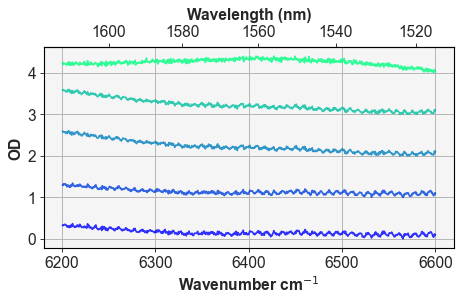

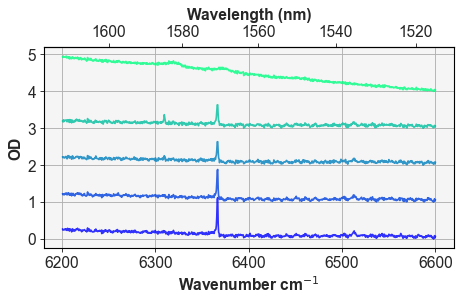

In [4]:
plt.x_label = 'Wavenumber cm$^{-1}$'
plt.y_label = 'OD'
plt.sec_x_label = 'Wavelength (nm)'
plt.save = True
plt.folder = 'Documents/University/python_scripts/PhD_Thesis/Figures/Chapter-4/Plots/'
plt.format = 'svg'

fname = ['pi', 'sigma']

for index, polarisation in enumerate(polarisations):
    plt.title = polarisation
    plt.fname = fname[index]
    fig, ax = plt.plot_spectra(x_data=wavevector_sets[index], y_data=OD_sets[index], lims=[6600, 6200], shifter=1, data_labels=folder_list)